# Overview
A [swerve drive robot](https://team1640.com/wiki/index.php/Swerve_Central), despite being more mechanically complex, is arguably much simpler for a human to operate than other wheeled mobile robots. This is due to swerve drives being holonomic: they are capable of moving and/or rotating in any direction unlike, for example, a car which can move forwards and backwards but not right and left. Joysticks are naturally well-suited for holonomic control, so they are often used to operate swerve drive robots. It then becomes necessary to introduce a mapping from the space of joystick inputs to the space of the robot's feasible linear and angular velocities. In my experience, it is common to naively implement this mapping as a one-to-one correspondence.

In this notebook, I hope to show some of the drawbacks of the naive bijection mapping and present a novel mapping that avoids these drawbacks. The deviation of the proposed mapping from the naive mapping is more pronounced when the pivots are not equally-distanced and -spaced around the axis of rotation. For this reason, this method may be particularly useful when a robot's drive base is abnormally shaped (e.g. rectangular) or for performing sophisticated manuevers (e.g. operating with an axis-of-rotation fixed at one of the pivots).

# Background
## Controlling a Swerve Drive
A swerve drive consists of some number of pivotable wheels (typically 4) that can be both independently driven and steered, allowing a robot to move holonomically. Controlling a swerve drive robot consists of specifying two vectors at each moment in time:
- the linear velocity $\vec{v} = (v_x, v_y, 0)$ in the ground plane.
- the angular velocity $\vec{\omega} = (0, 0, \omega)$ around some axis of rotation, usually fixed at the centroid of the wheel base.

Given these two control vectors, the velocity for pivot $i$ that is necessary to achieve the desired motion can be uniquely determined using inverse kinematics (see the Appendix for the derivation). Let $\vec{v}_i$ denote the velocity of pivot $i$, let $\theta$ denote the angle the robot makes with the world coordinate frame, let $\vec{r}_i$ denote the position of pivot $i$ with respect to the axis of rotation, and let $R_z(\theta)$ denote the rotation matrix about the z-axis by angle $\theta$. Then the equation that relates pivot $i$'s velocity to the desired robot linear and angular velocity is as follows:
$$\vec{v}_i = \vec{v} + \vec{\omega} \times R_z(\theta) \vec{r}_i, \forall i$$

Since each pivot has a maximum possible speed $\vec{v}_\mathrm{max}$, the pivots constrain the robot's feasible linear and angular velocity as follows:
$$\lVert \vec{v} + \vec{\omega} \times R_z(\theta) \vec{r}_i \rVert \leq v_\mathrm{max}, \forall i$$

Notice the following properties of this constraint:
- $\vec{\omega} = \vec{0} \implies \lVert \vec{v} \rVert \leq v_\mathrm{max}$
- $\vec{v} = \vec{0} \implies \lVert \vec{\omega} \times R_z(\theta) \vec{r}_i \rVert \leq v_\mathrm{max}, \forall i \implies \lvert \omega \rvert \cdot \lVert \vec{r}_i \rVert \leq v_\mathrm{max}, \forall i \implies \lvert \omega \rvert \leq \frac{v_\mathrm{max}}{\underset{i}{\max} \lVert \vec{r}_i \rVert} =: \omega_\mathrm{max}$

## The Human Interface
Given that swerve drives require two control vectors, it is natural for a swerve drive robot to be operated by a human using two joysticks: one for controlling linear velocity and the other for angular velocity. Assuming the joystick values range from $-1$ to $1$, we can define joystick input vectors as follows:
- the linear joystick vector: $\vec{\mathrm{v}} = (\mathrm{v}_x, \mathrm{v}_y, 0)$, such that $\mathrm{v}_x^2 + \mathrm{v}_y^2 \leq 1$
- the angular joystick vector: $\vec{\mathrm{w}} = (0, 0, \mathrm{w})$, such that $-1 \leq \mathrm{w} \leq 1$

Note that joystick variables which range from -1 to 1 will be denoted in a serif font (e.g. $\vec{\mathrm{v}}$ and $\vec{\mathrm{w}}$) and real variables which are constrained by the robot's physical limitations will be denoted in a script font (e.g. $\vec{v}$ and $\vec{\omega}$).

If we plot the three degrees of freedom in the joystick inputs ($\mathrm{v}_x$, $\mathrm{v}_y$, and $\mathrm{w}$), we discover that the joystick input space is cylindrical.

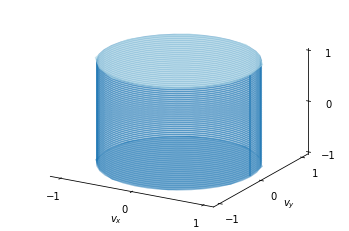

In [69]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d
from mpl_toolkits import mplot3d
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot cylinder
z = np.linspace(-1, 1, 500)
theta = np.linspace(0, 2*np.pi, 36)
z_grid, theta_grid = np.meshgrid(z, theta)
x_grid = np.cos(theta_grid)
y_grid = np.sin(theta_grid)

ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$\omega$')

ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.set_proj_type('ortho')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.plot_wireframe(x_grid, y_grid, z_grid, rstride=20, cstride=10, alpha=0.5)

# Plot cap and bottom
p1 = Circle((0, 0), 1, alpha=0.5, color='lightblue')
p2 = Circle((0, 0), 1, alpha=0.5)
ax.add_patch(p1)
ax.add_patch(p2)
art3d.patch_2d_to_3d(p1, z=1, zdir='z')
art3d.patch_2d_to_3d(p2, z=-1, zdir='z')

plt.show()

# Defining a Mapping

With the above definitions, the problem is to find a mapping from $(\vec{\mathrm{v}}, \vec{\mathrm{w}})$ to $(\vec{v}, \vec{\omega})$.

## Visualizing the Swerve Control Space

The space of feasible linear and angular velocities for the swerve drive, on the other hand, is much more complex as it depends on the number of pivots and their locations with respect to the axis of rotation.